Simple muon and neutrino flux calculation
-----------------------------------------

This notebook demonstrates the basic use case of the solver. It calculates the atmospheric lepton flux, taking most of the configuration values from the 'global' config file `mceq_config.py`. The interaction model and the primary cosmic ray flux model are selected during initialization.

In [1]:
#basic imports and ipython setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
os.chdir('..')


#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config
#import primary model choices
import CRFluxModels.CRFluxModels as pm

#import sys
#sys.path.append('/Users/mhuber/AtmosphericMuons_Anatoli/strawman-hadint/references')
#sys.path.append('/Users/mhuber/MatrixCascadeEquationCode/MCEq')

#import references as ref


Create an instance of an MCEqRun class. Most of its areguments are contained in the `config` dictionary from the `mceq_config` module. Look into or edit `mceq_config.py`.

If the initialization succeeds it will print out some information according to the debug level. 

In [2]:
print('###################################################')
print('Run the scripts with Sibyll as hadronic interaction model')
print('###################################################')
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.CombinedGHandHG, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0,
na49_model=(None,'all'),
#expand the rest of the options from mceq_config.py
**config
)
#mceq_run.set_single_primary_particle(E=1.e5,corsika_id=201)




###################################################
Run the scripts with Sibyll as hadronic interaction model
###################################################
InteractionYields::_load(): Looking for /Users/mhuber/AtmosphericMuons_Anatoli/MCEq/data/SIBYLL23_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file /Users/mhuber/AtmosphericMuons_Anatoli/MCEq/data/decays_v1_compact.ppd

Hadrons and stable particles:

"p", "p-bar", "n-bar", "n"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S", 
"D+", "D-", "Ds+", "Ds-", "D0", "D0-bar"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "gamma", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", 
"k_numu", "k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", 
"k_antinutau", "k_antinumu", "k_antinue", "obs_nue", "pr_nue", "pr_numu", "pr_nutau", "obs_antinutau", 
"ob

__________

If everything succeeds than the last message should be something like

`MCEqRun::set_primary_model():  HillasGaisser2012 H3a`.

The spline interpolating the depth-density relation of an atmosphere will be caluclated and cached during the first run. 

Integrate
---------
Now, run the solve command to integrate the cascade equations starting from the top of the atmosphere
down to the observation level `h_obs` (see config).

In [3]:
#load yield matrix
_yield = np.load('data/na49_yields_pC.npy').item()
_yield.pop('e_grid')
print('Particles that can be replaced by SHIN model: ',np.array(_yield.keys())[:,1])

mlist = [
    ('SIBYLL2.3', dict(interaction_model='SIBYLL2.3' , na49_model=(None,'all'))),
    ('SHIN_pi+', dict(interaction_model='SIBYLL2.3' , na49_model=('pC',[211]))),
    ('SHIN_pi-', dict(interaction_model='SIBYLL2.3' , na49_model=('pC',[-211]))),
    ('SHIN_p', dict(interaction_model='SIBYLL2.3' , na49_model=('pC',[2212]))),
    ('SHIN_pbar', dict(interaction_model='SIBYLL2.3' , na49_model=('pC',[-2212]))),
    ('SHIN_n', dict(interaction_model='SIBYLL2.3' , na49_model=('pC',[2112]))),
    ('SHIN_all', dict(interaction_model='SIBYLL2.3' , na49_model=('pC',np.array(_yield.keys())[:,1])))
]

mag = 3.
mu_flux = {}
numu_flux = {}
nue_flux = {}
#save muon flux for different injected SHIN particles

for iacount, (name,iamodel) in enumerate(mlist): 
    mceq_run.set_interaction_model(force=True,**iamodel)
    mceq_run.solve()
    e_grid = mceq_run.y.e_grid
    mu_flux[name] = [mceq_run.get_solution('total_mu+', mag),
                        mceq_run.get_solution('total_mu-', mag)]

    numu_flux[name] = [mceq_run.get_solution('total_numu', mag),
                        mceq_run.get_solution('total_antinumu', mag)]
    
    nue_flux[name] = [mceq_run.get_solution('total_nue', mag),
                        mceq_run.get_solution('total_antinue', mag)]



('Particles that can be replaced by SHIN model: ', array([ -211, -2212,   211,  2112]))
MCEqRun::set_interaction_model():  SIBYLL23
Load again
InteractionYields::_load(): Looking for /Users/mhuber/AtmosphericMuons_Anatoli/MCEq/data/SIBYLL23_yields_compact_ledpm.bz2
InteractionYields:set_interaction_model():: Model SIBYLL23 already loaded.
MCEqRun::_init_default_matrices():Start filling matrices. Skip_D_matrix = True
MCEqRun::_convert_to_sparse():Converting to sparse (CSR) matrix format.
C Matrix info:
    density    : 3.41%
    shape      : 5368 x 5368
    nnz        : 981415
D Matrix info:
    density    : 1.11%
    shape      : 5368 x 5368
    nnz        : 318463
MCEqRun::_init_default_matrices():Done filling matrices.
MCEqRun::_calculate_integration_path(): X_surface = 1033.80949621
MCEqRun::_forward_euler(): Solver will perform 355 integration steps.
Performance:   3.83ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 1.47181415558 sec
MCEqRun::set_interacti

MCEq/data.py:948: UserWarning: Tried to replace set([2212]) particle(s) in yield matrix without success!
  warnings.warn('Tried to replace {0} particle(s) in yield matrix without success!'.format(set(r_list).difference(repl)))


MCEqRun::_convert_to_sparse():Converting to sparse (CSR) matrix format.
C Matrix info:
    density    : 3.41%
    shape      : 5368 x 5368
    nnz        : 981415
D Matrix info:
    density    : 1.11%
    shape      : 5368 x 5368
    nnz        : 318463
MCEqRun::_init_default_matrices():Done filling matrices.
MCEqRun::_forward_euler(): Solver will perform 355 integration steps.
Performance:   1.92ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.681933879852 sec
MCEqRun::set_interaction_model():  SIBYLL23
Load again
InteractionYields::_load(): Looking for /Users/mhuber/AtmosphericMuons_Anatoli/MCEq/data/SIBYLL23_yields_compact_ledpm.bz2
NA49 data from ('pC', [-2212]) interactions used to create YieldMatrix. 

Replaced secondaries: [-2212]
InteractionYields:set_interaction_model():: Model SIBYLL23 already loaded.
MCEqRun::_init_default_matrices():Start filling matrices. Skip_D_matrix = True
MCEqRun::_convert_to_sparse():Converting to sparse (CSR) matrix format.

Plot muon flux
--------------

In [4]:
def mcolor(iamodel_name):
    mcolors = {}
    # Choose the color of your model here
    mcolors['SHIN_pi+'] = ('purple',':',1)
    mcolors['SHIN_pi-'] = ('cyan','--',1)
    mcolors['SIBYLL2.3'] = ('r','-.',1)
    mcolors['SHIN_p'] = ('violet','--',1)
    mcolors['SHIN_pbar'] = ('k','--',1)
    mcolors['SHIN_n'] = ('g',':',2.5)
    mcolors['SHIN_kaons'] = ('b','-.',1)
    mcolors['SHIN_all'] = ('orange','-',1)
    mcolors['_'] = 'orange'
    mcolors['_'] = 'cyan'
    return mcolors[iamodel_name]

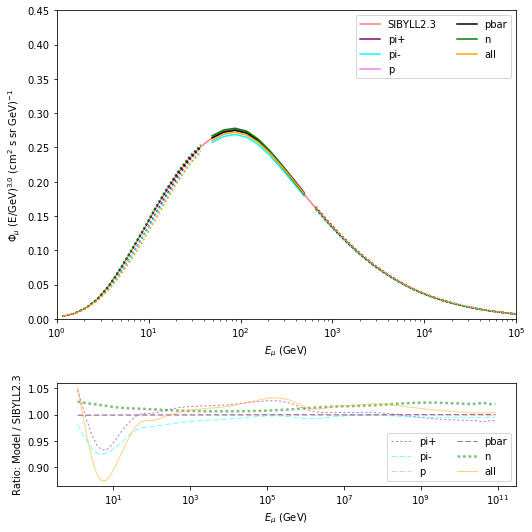

In [5]:
fig, ax = plt.subplots(2,1,figsize=(7.5,7.5),squeeze=False,gridspec_kw=dict(height_ratios=(3,1)))
sel = np.where(mceq_run.e_grid > 0.)

for iamodel, settings in mlist:
    if 'SHIN' not in iamodel:
        ax[0,0].semilogx(mceq_run.e_grid[sel], np.sum(mu_flux[iamodel],axis=0), 
                label=iamodel, color=mcolor(iamodel)[0], zorder=2,alpha=0.5)
    else:
        sel = np.where((mceq_run.e_grid >= 40.) &  (mceq_run.e_grid <= 500.))
        ax[0,0].semilogx(mceq_run.e_grid[sel], np.sum(mu_flux[iamodel],axis=0)[sel], 
                label=iamodel.split('_')[1], color=mcolor(iamodel)[0], zorder=2)
        
        sel = np.where((mceq_run.e_grid <=40.))
        ax[0,0].semilogx(mceq_run.e_grid[sel], np.sum(mu_flux[iamodel],axis=0)[sel], 
                color=mcolor(iamodel)[0], zorder=2,ls=':')
        
        sel = np.where((mceq_run.e_grid >= 500.))
        ax[0,0].semilogx(mceq_run.e_grid[sel], np.sum(mu_flux[iamodel],axis=0)[sel], 
                color=mcolor(iamodel)[0], zorder=2, ls=':')
        
        #also plot ratios
        ax[1,0].semilogx(mceq_run.e_grid, np.sum(mu_flux[iamodel],axis=0) / 
                         np.sum(mu_flux['SIBYLL2.3'],axis=0), 
                label=iamodel.split('_')[1], color=mcolor(iamodel)[0], zorder=2, alpha=0.5, 
                         ls=mcolor(iamodel)[1],lw=mcolor(iamodel)[2])
        

    
ax[0,0].set_ylabel(r"$\Phi_\mu$ (E/GeV)$^{" + str(mag) + "}$ (cm$^{2}$ s sr GeV)$^{-1}$")
ax[0,0].set_xlim(1,1e5)
ax[0,0].set_ylim(0,0.45)
ax[0,0].legend(ncol=2)
ax[0,0].set_xlabel(r"$E_{\mu}$ (GeV)")

ax[1,0].set_ylabel(r"Ratio: Model / SIBYLL2.3")
ax[1,0].legend(ncol=2)
ax[1,0].set_xlabel(r"$E_{\mu}$ (GeV)")

plt.tight_layout()
# nbu.save('vert_muons_' + model_str)

Plot muon charge ratio
----------------------

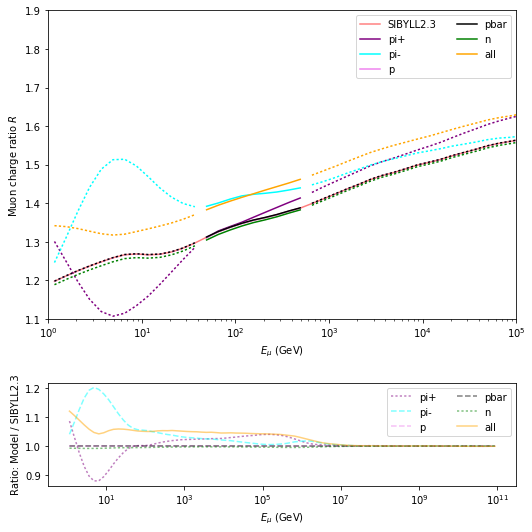

In [6]:
fig, ax = plt.subplots(2,1,figsize=(7.5,7.5),squeeze=False,gridspec_kw=dict(height_ratios=(3,1)))
sel = np.where(mceq_run.e_grid > 0.)

for iamodel, settings in mlist:
    if 'SHIN' not in iamodel:
        ax[0,0].semilogx(mceq_run.e_grid[sel], mu_flux[iamodel][0] /
                mu_flux[iamodel][1],
                label=iamodel, color=mcolor(iamodel)[0], zorder=2,alpha=0.5)
    else:
        sel = np.where((mceq_run.e_grid >= 40.) &  (mceq_run.e_grid <= 500.))
        ax[0,0].semilogx(mceq_run.e_grid[sel], mu_flux[iamodel][0][sel]/
                         mu_flux[iamodel][1][sel], 
                label=iamodel.split('_')[1], color=mcolor(iamodel)[0], zorder=2)
        
        sel = np.where((mceq_run.e_grid <=40.))
        ax[0,0].semilogx(mceq_run.e_grid[sel], mu_flux[iamodel][0][sel]/
                         mu_flux[iamodel][1][sel], 
                color=mcolor(iamodel)[0], zorder=2,ls=':')
        
        sel = np.where((mceq_run.e_grid >= 500.))
        ax[0,0].semilogx(mceq_run.e_grid[sel], mu_flux[iamodel][0][sel]/
                         mu_flux[iamodel][1][sel], 
                color=mcolor(iamodel)[0], zorder=2, ls=':')
        
        #also plot ratios
        ax[1,0].semilogx(mceq_run.e_grid, (mu_flux[iamodel][0]/
                         mu_flux[iamodel][1]) / 
                         (mu_flux['SIBYLL2.3'][0]/mu_flux['SIBYLL2.3'][1]), 
                label=iamodel.split('_')[1], color=mcolor(iamodel)[0], zorder=2, alpha=0.5, 
                         ls=mcolor(iamodel)[1])
        




ax[0,0].set_ylabel(r"Muon charge ratio $R$")
ax[0,0].set_xlim(1,1e5)
ax[0,0].set_ylim(1.1,1.9)
ax[0,0].legend(ncol=2)
ax[0,0].set_xlabel(r"$E_{\mu}$ (GeV)")

ax[1,0].set_ylabel(r"Ratio: Model / SIBYLL2.3")
ax[1,0].legend(ncol=2)
ax[1,0].set_xlabel(r"$E_{\mu}$ (GeV)")

plt.tight_layout()

Plot muon neutrino flux
-----------------------

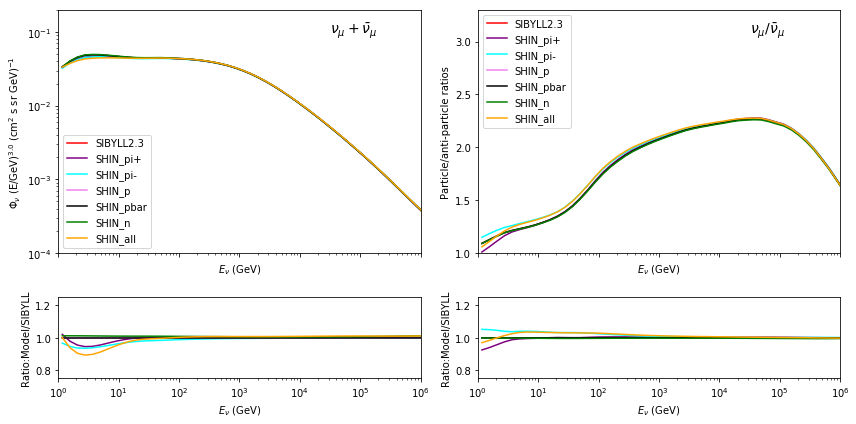

In [7]:
fig, ax = plt.subplots(2,2,figsize=(12,6),sharex=True,gridspec_kw=dict(height_ratios=(3,1)),squeeze=False)

# You can limit your energy range here
sel = np.where(mceq_run.e_grid > 0.)

for iamodel, settings in mlist:
    ax[0,0].loglog(mceq_run.e_grid[sel], np.sum(numu_flux[iamodel],axis=0), 
                label=iamodel, color=mcolor(iamodel)[0])
    
    ax[0,1].semilogx(mceq_run.e_grid[sel], (numu_flux[iamodel][0]/ numu_flux[iamodel][1])[sel], 
                label=iamodel, color=mcolor(iamodel)[0])
    
    if 'SHIN' in iamodel:
        ax[1,0].semilogx(mceq_run.e_grid[sel], np.sum(numu_flux[iamodel],axis=0)/
                       np.sum(numu_flux['SIBYLL2.3'],axis=0)       , 
                       label='_nolabel_', color=mcolor(iamodel)[0])
        
        ax[1,1].semilogx(mceq_run.e_grid[sel], (numu_flux[iamodel][0]/ numu_flux[iamodel][1])[sel]/
                        (numu_flux['SIBYLL2.3'][0]/ numu_flux['SIBYLL2.3'][1])[sel] , 
                label=iamodel, color=mcolor(iamodel)[0])
    
    
ax[0,0].set_ylabel(r"$\Phi_\nu$ (E/GeV)$^{" + str(mag) + "}$ (cm$^{2}$ s sr GeV)$^{-1}$")
ax[0,0].set_xlim(1,1e6)
ax[0,0].set_ylim(1e-4,2e-1)
ax[0,0].text(0.75,0.9,r'$\nu_\mu + \bar{\nu}_\mu$',fontsize=14,
             transform = ax[0,0].transAxes)

ax[0,0].legend(ncol=1, loc='lower left')

ax[0,1].set_ylabel(r"Particle/anti-particle ratios")
ax[0,1].set_xlim(1,1e6)
ax[0,1].set_ylim(1,3.3)
ax[0,1].text(0.75,0.9,r'$\nu_\mu/\bar{\nu}_\mu$',fontsize=14,
             transform = ax[0,1].transAxes)

ax[0,1].legend(ncol=1, loc='upper left')
ax[0,0].set_xlabel(r"$E_{\nu}$ (GeV)")
ax[0,1].set_xlabel(r"$E_{\nu}$ (GeV)")
ax[1,0].set_xlabel(r"$E_{\nu}$ (GeV)")
ax[1,1].set_xlabel(r"$E_{\nu}$ (GeV)")

ax[1,1].set_ylim(0.75,1.25)
ax[1,0].set_ylim(0.75,1.25)

ax[1,1].set_ylabel(r"Ratio:Model/SIBYLL")
ax[1,0].set_ylabel(r"Ratio:Model/SIBYLL")


plt.tight_layout()

Plot the electron neutrino flux
---------------

/Users/mhuber/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


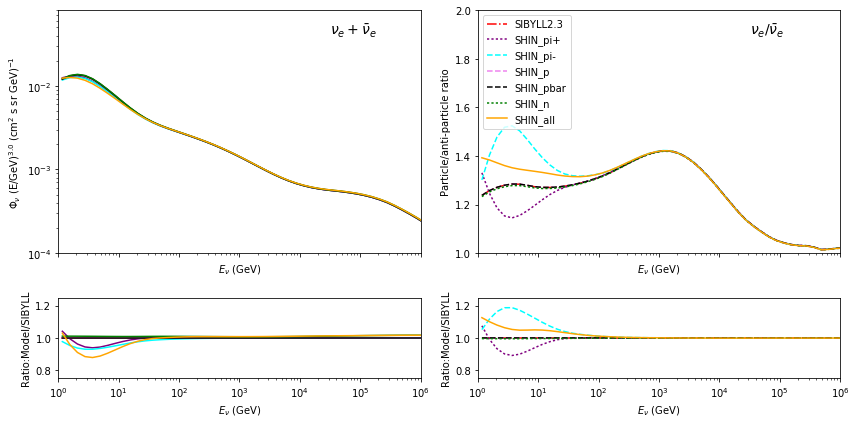

In [8]:
fig, ax = plt.subplots(2,2,figsize=(12,6),sharex=True,gridspec_kw=dict(height_ratios=(3,1)),squeeze=False)

# You can limit your energy range here
sel = np.where(mceq_run.e_grid > 0.)

for iamodel, settings in mlist:
    ax[0,0].loglog(mceq_run.e_grid[sel], np.sum(nue_flux[iamodel],axis=0), 
                label='_nolabel_', color=mcolor(iamodel)[0])
    
    ax[0,1].semilogx(mceq_run.e_grid[sel], (nue_flux[iamodel][0]/ nue_flux[iamodel][1])[sel], 
                label=iamodel, color=mcolor(iamodel)[0],ls=mcolor(iamodel)[1])
    
    ax[1,0].semilogx(mceq_run.e_grid[sel], np.sum(nue_flux[iamodel],axis=0)/
                   np.sum(nue_flux['SIBYLL2.3'],axis=0), 
                   label='_nolabel_', color=mcolor(iamodel)[0])
    
    ax[1,1].semilogx(mceq_run.e_grid[sel], (nue_flux[iamodel][0]/ nue_flux[iamodel][1])[sel]/
                     (nue_flux['SIBYLL2.3'][0]/ nue_flux['SIBYLL2.3'][1])[sel], 
                     label='_nolabel_', color=mcolor(iamodel)[0],ls=mcolor(iamodel)[1])
    
ax[0,0].set_ylabel(r"$\Phi_\nu$ (E/GeV)$^{" + str(mag) + "}$ (cm$^{2}$ s sr GeV)$^{-1}$")
ax[0,0].set_xlim(1,1e6)
ax[0,0].set_ylim(1e-4,8e-2)
ax[0,0].text(0.75,0.9,r'$\nu_e + \bar{\nu}_e$',fontsize=14,
             transform = ax[0,0].transAxes)

ax[0,0].legend(ncol=1, loc='lower left')

ax[0,1].set_ylabel(r"Particle/anti-particle ratio")
ax[0,1].set_xlim(1,1e6)
ax[0,1].set_ylim(1,2.0)
ax[0,1].text(0.75,0.9,r'$\nu_e/\bar{\nu}_e$',fontsize=14,
             transform = ax[0,1].transAxes)

ax[0,1].legend(ncol=1, loc='upper left')
ax[0,0].set_xlabel(r"$E_{\nu}$ (GeV)")
ax[0,1].set_xlabel(r"$E_{\nu}$ (GeV)")
ax[1,0].set_xlabel(r"$E_{\nu}$ (GeV)")
ax[1,1].set_xlabel(r"$E_{\nu}$ (GeV)")

ax[1,1].set_ylim(0.75,1.25)
ax[1,0].set_ylim(0.75,1.25)

ax[1,1].set_ylabel(r"Ratio:Model/SIBYLL")
ax[1,0].set_ylabel(r"Ratio:Model/SIBYLL")

plt.tight_layout()